In [1]:
from galileojp.k3s import K3SGateway

import datetime
import json
from collections import defaultdict
import pandas as pd
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import json

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 11})
sns.set_theme()
sns.set_context("talk")

In [2]:
gw = K3SGateway.from_env()

In [3]:
exps = [
    # Xeon with GPU
    ('202207171020-8bef', 'Xeon', 'eb-b-xeongpu-0'),
    
    # Jetson Nano
    ('202207171026-e2ba', 'Nano', 'eb-a-jetson-nano-0'),
    
    # Jetson TX2
    ('202207171029-ea87', 'TX2', 'eb-a-jetson-tx2-0'),
    
    # Jetson NX
    ('202207171032-a9c6', 'NX', 'eb-a-jetson-nx-0')
]

# Cross Device Analysis

In this notebook we are going to investigate the performance and resource usage of four devices hosting an OpenFaaS function that serves Mobilenet.
The network is loaded via TFlite.

The devices are: 
* Xeon CPU with GPU (GPU not used)
* Nvidia Jetson Nano
* Nvidia Jetson TX2
* Nvidia Jetson NX

# Performance

First, we are going to load the preprocessed traces, which already contain the Round Trip Time (RTT) for each experiment (one experiment per device).

In [4]:
dfs = []
for exp in exps:
    traces = gw.preprocessed_traces(exp[0])
    traces['Host'] = exp[1]
    dfs.append(traces)
traces_df = pd.concat(dfs)
traces_df.columns

original traces size: 100
after -1 filter traces size: 100
original traces size: 100
after -1 filter traces size: 100
original traces size: 100
after -1 filter traces size: 100
original traces size: 100
after -1 filter traces size: 100


Index(['result', 'table', '_start', '_stop', '_time', 'value', '_field',
       '_measurement', 'client', 'created', 'done', 'exp_id', 'headers',
       'response', 'sent', 'server', 'service', 'status', 'rtt',
       'final_server', 'origin_zone', 'origin_cluster', 'latency_gateway',
       'start', 'end', 'exec', 'latency', 'final_ip', 'final_port', 'pod_name',
       'pod_image', 'function', 'dest_zone', 'dest_cluster', 'Host'],
      dtype='object')

## Performance

After loading the traces, we can easily plot the RTT

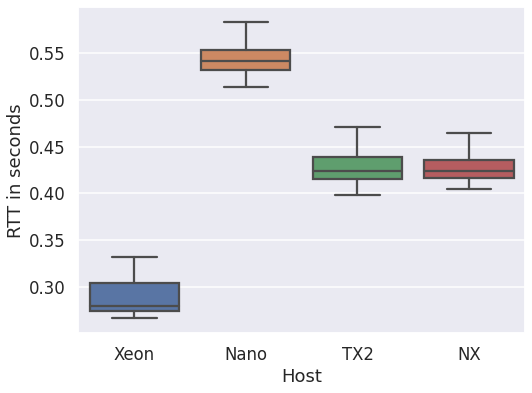

In [22]:
plt.figure(figsize = (8,6))
g = sns.boxplot(x='Host', y='rtt', data=traces_df,showfliers=False)
g.set_ylabel('RTT in seconds')
plt.savefig('figures/rtt-per-host-boxplot.pdf')

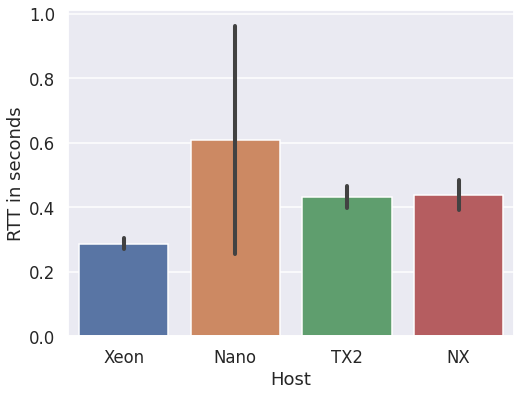

In [23]:
plt.figure(figsize = (8,6))
g = sns.barplot(x='Host', y='rtt', data=traces_df, ci='sd')
g.set_ylabel('RTT in seconds')
plt.savefig('figures/rtt-per-host-barplot.pdf')

# Telemetry data

In [7]:
tels = []
for exp in exps:
    exp_id = exp[0]
    node = exp[2]
    tel = gw.preprocessed_telemetry(exp_id)
    tel = tel[tel['node'] == node]
    tel['Host'] = exp[1]
    tels.append(tel)
    
telemetry_df = pd.concat(tels)
telemetry_df.head(5)

,result,table,_start,_stop,_time,value,_field,_measurement,exp_id,metric,node,ts,subsystem,Host
ts,,,,,,,,,,,,,,
1970-01-01 00:00:01.466998507,_result,0,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:32.329000+00:00,9.045226,value,telemetry,202207171020-8bef,cpu,eb-b-xeongpu-0,1.466999,NaN,Xeon
1970-01-01 00:00:02.469414403,_result,1,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:33.331000+00:00,2.020202,value,telemetry,202207171020-8bef,cpu,eb-b-xeongpu-0,2.469414,NaN,Xeon
1970-01-01 00:00:03.467515876,_result,2,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:34.329000+00:00,2.512563,value,telemetry,202207171020-8bef,cpu,eb-b-xeongpu-0,3.467516,NaN,Xeon
1970-01-01 00:00:04.467795779,_result,3,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:35.330000+00:00,13.432836,value,telemetry,202207171020-8bef,cpu,eb-b-xeongpu-0,4.467796,NaN,Xeon
1970-01-01 00:00:05.466962268,_result,4,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:36.329000+00:00,13.000000,value,telemetry,202207171020-8bef,cpu,eb-b-xeongpu-0,5.466962,NaN,Xeon


# Node CPU usage

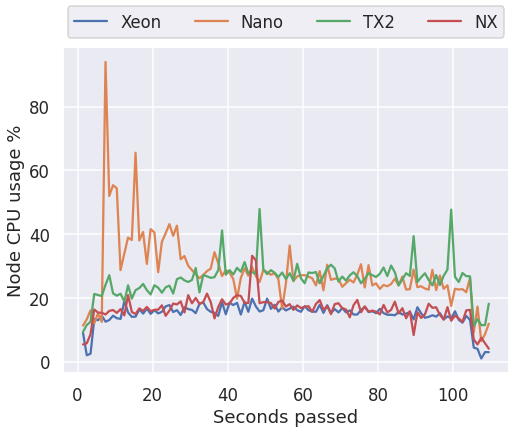

In [26]:
plt.figure(figsize = (8,6))
tel = telemetry_df[telemetry_df['metric'] == 'cpu']
g = sns.lineplot(x='ts',y='value',hue='Host',data=tel)
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           fancybox=True, shadow=False, ncol=5)
g.set_xlabel('Seconds passed')
g.set_ylabel('Node CPU usage %')
plt.savefig('figures/mobilenet-node-cpu-usage-lineplot.pdf')

Get the container ID. This is necessary, as in the telemetry dataframe, Pod relevant metrics have the container id.

In [9]:
container_ids = {}
for exp in exps:
    exp_id = exp[0]
    node = exp[1]
    container_id = gw.get_replicas(exp_id).iloc[0]['container_id']
    container_ids[node] = container_id
container_ids

{'Xeon': '2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d6199e636afda16b86466',
 'Nano': '633f7f2b006bacfc5099f61b9221c6d808b9d3dfe206fcbed2245a3bd65ad44a',
 'TX2': 'ecbcd714e6f176d648b761db6eb29901c9335d990f6c64f02ff8a17bc40cb109',
 'NX': '691dc725d9bc7a57d0890aa0c6bb7a281340819ce094eda0f559309c0487a65c'}

# Container Memory Usage

In [10]:
memories = []
for k, v in container_ids.items():
    tel = telemetry_df[telemetry_df['Host'] == k]
    memory = tel[tel['metric'] == 'kubernetes_cgrp_memory']
    memory = memory[memory['subsystem'] == v]
    memory['Host'] = k
    memories.append(memory)
memory_df = pd.concat(memories)
memory_df

,result,table,_start,_stop,_time,value,_field,_measurement,exp_id,metric,node,ts,subsystem,Host
ts,,,,,,,,,,,,,,
1970-01-01 00:00:00.992835929,_result,1744,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:31.855000+00:00,35.975168,value,telemetry,202207171020-8bef,kubernetes_cgrp_memory,eb-b-xeongpu-0,0.992836,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,Xeon
1970-01-01 00:00:02.015717437,_result,1745,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:32.877000+00:00,35.975168,value,telemetry,202207171020-8bef,kubernetes_cgrp_memory,eb-b-xeongpu-0,2.015717,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,Xeon
1970-01-01 00:00:03.008770158,_result,1746,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:33.871000+00:00,35.975168,value,telemetry,202207171020-8bef,kubernetes_cgrp_memory,eb-b-xeongpu-0,3.008770,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,Xeon
1970-01-01 00:00:04.004441907,_result,1747,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:34.866000+00:00,94.363648,value,telemetry,202207171020-8bef,kubernetes_cgrp_memory,eb-b-xeongpu-0,4.004442,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,Xeon
1970-01-01 00:00:05.006646563,_result,1748,1970-01-01 00:00:00+00:00,2022-07-18 12:11:00.587716+00:00,2022-07-17 10:20:35.868000+00:00,104.656896,value,telemetry,202207171020-8bef,kubernetes_cgrp_memory,eb-b-xeongpu-0,5.006647,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,Xeon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:45.892548356,_result,2066,1970-01-01 00:00:00+00:00,2022-07-18 12:11:18.700401+00:00,2022-07-17 10:33:58.871000+00:00,296.701952,value,telemetry,202207171032-a9c6,kubernetes_cgrp_memory,eb-a-jetson-nx-0,105.892548,691dc725d9bc7a57d0890aa0c6bb7a281340819ce094ed...,NX
1970-01-01 00:01:46.861237798,_result,2067,1970-01-01 00:00:00+00:00,2022-07-18 12:11:18.700401+00:00,2022-07-17 10:33:59.840000+00:00,296.701952,value,telemetry,202207171032-a9c6,kubernetes_cgrp_memory,eb-a-jetson-nx-0,106.861238,691dc725d9bc7a57d0890aa0c6bb7a281340819ce094ed...,NX
1970-01-01 00:01:47.718503509,_result,2068,1970-01-01 00:00:00+00:00,2022-07-18 12:11:18.700401+00:00,2022-07-17 10:34:00.697000+00:00,296.701952,value,telemetry,202207171032-a9c6,kubernetes_cgrp_memory,eb-a-jetson-nx-0,107.718504,691dc725d9bc7a57d0890aa0c6bb7a281340819ce094ed...,NX


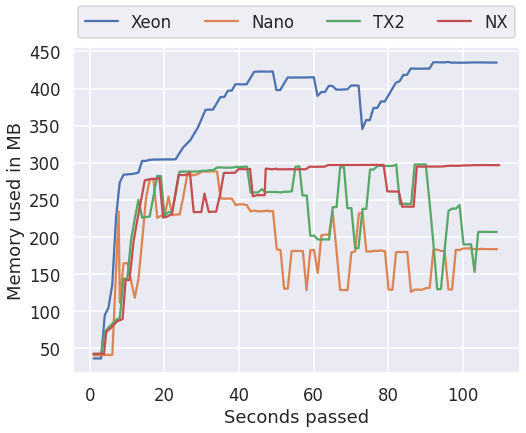

In [28]:
# Memory usage per container
plt.figure(figsize = (8,6))
g = sns.lineplot(x='ts',y='value',data=memory_df,hue='Host')
# g.set_title('Memory')
g.set_ylabel('Memory used in MB')
g.set_xlabel('Seconds passed')
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           fancybox=True, shadow=False, ncol=5)
plt.savefig('figures/mobilenet-memory-usage.pdf')

# Container CPU usage

In [13]:
dfs = []
for node, container_id in container_ids.items():
    for exp in exps:
        if exp[1] == node:
            exp_id = exp[0]
            break
    cpu = gw.get_cpu_container(exp_id, container_id)
    cpu['Host'] = node
    dfs.append(cpu)
cpu_df = pd.concat(dfs)
cpu_df

,result,table,_start,_stop,_time,value,_field,_measurement,exp_id,metric,node,subsystem,ts,value_ms,milli_cores,percentage,percentage_relative,Host
ts,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.969502379,_result,0,1970-01-01 00:00:00+00:00,2022-07-18 12:13:40.836517+00:00,2022-07-17 10:20:31.831000+00:00,2.927122e+08,value,telemetry,202207171020-8bef,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,1658053231.8317404,292.712186,NaN,NaN,NaN,Xeon
1970-01-01 00:00:01.970195701,_result,1,1970-01-01 00:00:00+00:00,2022-07-18 12:13:40.836517+00:00,2022-07-17 10:20:32.832000+00:00,2.928362e+08,value,telemetry,202207171020-8bef,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,1658053232.8324337,292.836243,0.123971,0.012397,0.003099,Xeon
1970-01-01 00:00:02.969526460,_result,2,1970-01-01 00:00:00+00:00,2022-07-18 12:13:40.836517+00:00,2022-07-17 10:20:33.831000+00:00,2.929621e+08,value,telemetry,202207171020-8bef,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,1658053233.8317645,292.962106,0.125776,0.012578,0.003144,Xeon
1970-01-01 00:00:03.967218568,_result,3,1970-01-01 00:00:00+00:00,2022-07-18 12:13:40.836517+00:00,2022-07-17 10:20:34.829000+00:00,3.460619e+08,value,telemetry,202207171020-8bef,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,1658053234.8294566,346.061880,53.062984,5.306298,1.326575,Xeon
1970-01-01 00:00:04.967132022,_result,4,1970-01-01 00:00:00+00:00,2022-07-18 12:13:40.836517+00:00,2022-07-17 10:20:35.829000+00:00,6.545885e+08,value,telemetry,202207171020-8bef,kubernetes_cgrp_cpu,eb-b-xeongpu-0,2a5f73f46064379581047e93dd4c30cf67e0a32f1a5d61...,1658053235.82937,654.588517,308.312877,30.831288,7.707822,Xeon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:01:44.968784127,_result,104,1970-01-01 00:00:00+00:00,2022-07-18 12:13:56.655978+00:00,2022-07-17 10:33:57.947000+00:00,4.371832e+10,value,telemetry,202207171032-a9c6,kubernetes_cgrp_cpu,eb-a-jetson-nx-0,691dc725d9bc7a57d0890aa0c6bb7a281340819ce094ed...,1658054037.9476361,43718.315776,411.689568,41.168957,6.861493,NX
1970-01-01 00:01:45.970677171,_result,105,1970-01-01 00:00:00+00:00,2022-07-18 12:13:56.655978+00:00,2022-07-17 10:33:58.949000+00:00,4.371852e+10,value,telemetry,202207171032-a9c6,kubernetes_cgrp_cpu,eb-a-jetson-nx-0,691dc725d9bc7a57d0890aa0c6bb7a281340819ce094ed...,1658054038.9495292,43718.517376,0.201479,0.020148,0.003358,NX
1970-01-01 00:01:46.969597850,_result,106,1970-01-01 00:00:00+00:00,2022-07-18 12:13:56.655978+00:00,2022-07-17 10:33:59.948000+00:00,4.371936e+10,value,telemetry,202207171032-a9c6,kubernetes_cgrp_cpu,eb-a-jetson-nx-0,691dc725d9bc7a57d0890aa0c6bb7a281340819ce094ed...,1658054039.9484499,43719.364768,0.846885,0.084689,0.014115,NX


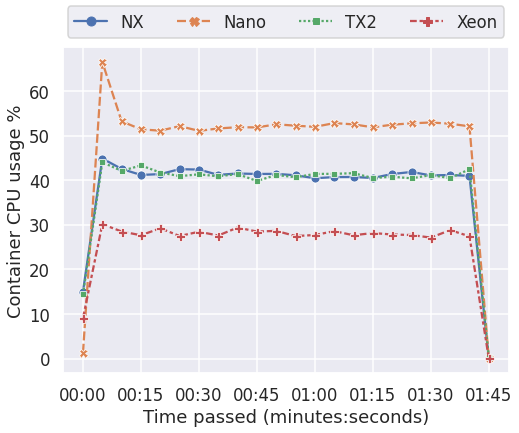

In [29]:
plt.figure(figsize = (8,6))

# Show minutes and seconds
time_format = "%M:%S"
time_form = DateFormatter(time_format)

data = cpu_df.groupby(['Host']).resample('5S').mean()
g = sns.lineplot(x='ts',y='percentage',hue='Host',data=data,style='Host',dashes=True,markers=True)
g.set_ylabel('Container CPU usage %')
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           fancybox=True, shadow=False, ncol=len(exps))
g.xaxis.set_major_formatter(time_form)
g.set_xlabel('Time passed (minutes:seconds)')
plt.savefig('figures/mobilenet-container-cpu-usage-lineplot.pdf')

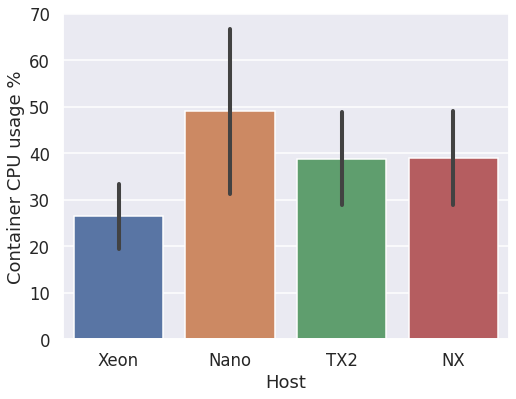

In [30]:
plt.figure(figsize = (8,6))

g = sns.barplot(x='Host', y='percentage', data=cpu_df, ci='sd')
g.set_ylabel('Container CPU usage %')

plt.savefig('figures/mobilenet-container-cpu-usage-barplot.pdf')